#### Mini-Project # 4

This project will focus on suitability analysis with raster data. Your tasks will be both conceptual-level and technical. 

At the conceptual level, you will define a suitability model of your choice, for an area of your choice. See https://en.wikipedia.org/wiki/Suitability_model for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens: these are often in underutilized land in residential land uses, with good soils, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, has mild temperatures, low levels of soil erosion, has vegeration (eg derived from satellite imagery using NDVI), etc. Feel free to use the imagery layers we explored or mentioned during the raster-focused lectures. One of the cells in the last raster notebook contained a list of about a dozen such layers available through AGOL - but feel free to find more. You can use any two of the map combination techniques discussed in the lecture on Thu 5/9. You should clearly identify the map combination technique you use, and discuss any uncertainty issues associated with these specific techniques. 

As the outcome of this part, you will need to a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons. In your model you will need to combine at least 3 raster data layers.

The second part will involve implementing your suitability model using arcgis raster functions. For this exercise, we'll only use local functions, and possibly focal_statistics. This is the current state of implementation of raster functions accessible through python API and in ArcGIS Online. Examples of what works are in the lecture notebooks. Look throufgh the last notebook carefully, as there are a few extra cells not shown in the lecture, which demonstrate *working* map combination examples for different types of layers. 

Be creative - but I'd rather not have you wander into blind alleys too much as you look for a declared function and it is simply not there. Note that since some functions are associated with raster services, they depend on the version of the server a particular imagery layer is served from. See in the lecture notebooks how you can retrieve the version of API supported by each layer, and which functions are supported in each API. 

The third part will be a brief write-up comparing the two output rasters generated for your suitability model using the two map combination techniques. 

The notebook should include documentation of the steps, as usually.

### Names: Ittoop Shinu Shibu, Bernard Wong

### IDs: A13719148, A15268417


1. Formulate a suitability model (markdown, about 100 words)

We're aiming to discover the areas that need the most attention regarding landslides in San Benito specifically. This area seems to have many issues with landslides making roads dangerous, so as a result we hope that our map will help locate these danger areas, so that extra precautions can be made. The three areas/layers that we've decided to focus on are rainfall, slope, and soil erosion. These are one of the biggest determining factors for landslides, as high levels of rainfall, slope, and soil erosion are positive predictors. After coming up with our suitability model, precautions such as extra rain-gutters or extra plantation in danger zones should hopefully alleviate the effects landslides have on San Benito.

In [1]:
# 2. Imports, etc. 
from arcgis import GIS
from IPython.display import display
gis = GIS(username='ishibu_UCSDOnline')
import arcgis.raster
from arcgis.raster import *
from arcgis.geometry import *

Enter password: ········


In [2]:
# 3. List imagery layers to be used in your model. This cell should contian layer definitions. 
# Include at least three initial raster sources. 

In [3]:
from IPython.display import HTML
usa_mean_rainfall = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", gis) 
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',gis)
usa_slope = slope(dem=usa_elevation, slope_type='DEGREE', z_factor=10)
usa_soil_erosion = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erosion_Class/ImageServer',gis)
#usa_slope = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer", gis)

In [4]:
# 4. Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

In [5]:
counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[0]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06069'", return_geometry=True)
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

study_area_ex = Geometry(study_area_geom).geoextent  # or just 'extent'

# then create the extent as a dict from the returned tuple 

tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

# to be correcter, let's also add CRS:
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
usa_slope.extent = study_area_extent
usa_mean_rainfall.extent = study_area_extent
usa_soil_erosion.extent = study_area_extent

5. Name the two map combination techniques you will use to combine the data and describe their pros and cons (markdown) 

The first technique we will be using is the exclusionary screening from the dominance technique. We will be clipping and converting each raster of rainfall, slope and erosion to a binary raster to perform raster calculations using the function raster_calculator. We chose to convert the raster into a binary raster because we only wanted to check if higher slopes and precipitation resulted in high amount of soil erosion. The issue with binary raster combination is that you generalise a lot of the data. Hence, you might either lose a lot of area or have a lot of area.
<br>The second technique we used was weighted voting from the contributory technique. Using all the binary remapped rasters, we were able to add them together with what we deemed was the proper weights. We thought that the slope was the most important factor for determining landslides (from doing a quick google search of causes) and then determined that rainfall was next important, with erosion being the least important. The issue with weighted voting is that there isn't necessarily a 'correct' answer or weight; typically, weights are up for debate, and as a result this combination varies depending on what weights you choose

In [6]:
# 6. Prepare your input layers for map combination: 
# clip to AOI, remap/normalize, add color map, visualize the layers and legends. 

In [7]:
rainfall_clip = clip(raster=usa_mean_rainfall,geometry=study_area_geom)
slope_clip = clip(raster=usa_slope, geometry=study_area_geom)
erosion_clip = clip(raster=usa_soil_erosion, geometry=study_area_geom)
clrmap2 = [[1, 230, 0, 0], [0, 38, 115, 0]]
erosion_clip = remap(raster=erosion_clip, input_ranges=[1,3, 3,5], output_values=[0, 1],  astype='U8')
erosion_c_clip = colormap(erosion_clip, colormap=clrmap2)
clrmap6 =  [[1, 255, 105, 0], [0, 255, 255, 0]]
rainfall_clip = remap(raster=rainfall_clip, input_ranges=[0.0, 20.0, 20.0, 300.0], output_values=[0, 1],  astype='U8')
rainfall_c_clip = colormap(rainfall_clip, colormap=clrmap6)
slope_clip = remap(raster=slope_clip, input_ranges=[0.0,45.0, 45.0,90.0],  output_values=[0,1],  astype='U8')
slope_c_clip = colormap(slope_clip, colormap=clrmap2)

In [8]:
# 7a. Generate a composite raster layer for your first map combination technique
# name of the technique (refer to lecture PPT):

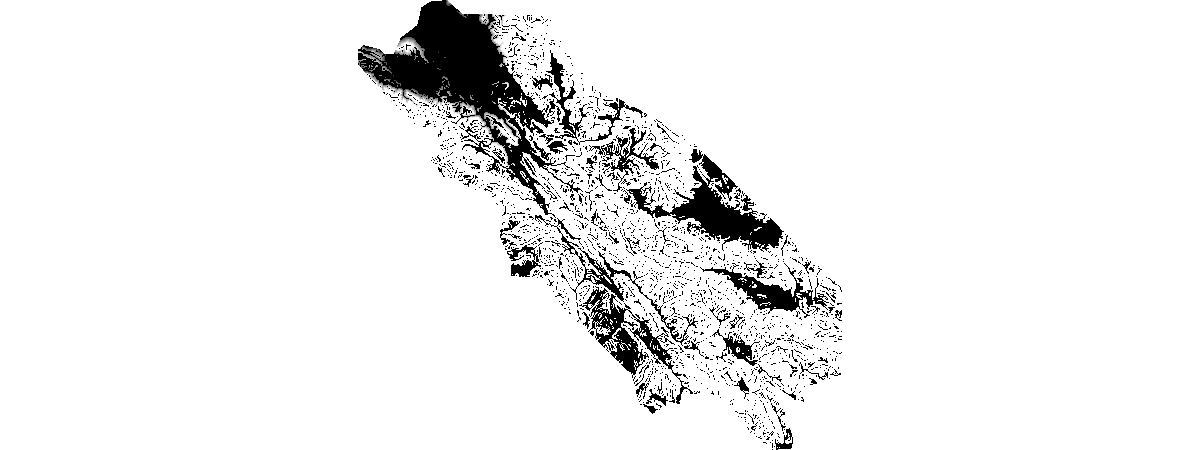

In [9]:
# Used dominance technique: exclusionary screening
rc1 = raster_calculator(rasters = [slope_c_clip, erosion_c_clip, rainfall_c_clip], input_names = ["a","b", "c"], expression = "a * b * c", extent_type='FirstOf', cellsize_type='FirstOf', astype='U8')
rc1

In [10]:
# 7b. Generate a composite raster layer for your second map combination technique
# name of the technique (refer to lecture PPT):

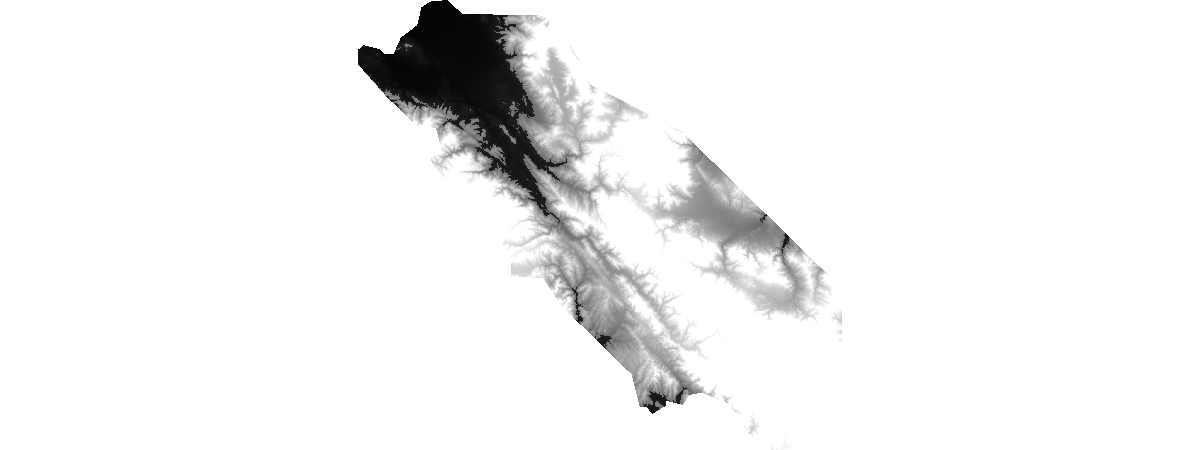

In [11]:
rc2 = raster_calculator(rasters = [slope_c_clip, erosion_c_clip, rainfall_c_clip], 
                        input_names = ["a","b", "c"], expression = "2*a + .1*b + .25*c", 
                        extent_type='FirstOf', cellsize_type='FirstOf', astype='U8')
rc2

In [12]:
# 8. Compare the results, and describe how different map combination techniques resulted in different outputs (or not.)
# 

In [13]:
map3 = gis.map()
map3.extent = study_area_extent        
map3.legend=True
#map3.add_layer(slope_c_clip)
map3.add_layer(rc1)
map3
# The map shows that areas that have high precipitation and slopes results in high amounts of soil erosion. Hence, 
# high precipitation and slopes result in a higher chance of landslides occuring in those area.

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [14]:
combine_map2 = gis.map()
combine_map2.extent = study_area_extent       
combine_map2.legend=True
combine_map2.add_layer(rc2)
combine_map2

MapView(layout=Layout(height='400px', width='100%'), legend=True)

The maps of the two combination maps look extremely similar. If you take a look at the areas of low terrain (the darker areas), the two maps both have the same dark locations. The patterns of low terrain and high terrain also remain very similar between the two maps. However, the maps also do have stark differences. Exclusionary screening is very suddent, and jumps very quickly from low to high terrains. However, the weighted voting is much more smooth, and progresses from low to high less quickly than exclusionary screening.

# Issue Report

While using the function raster_calculator, we came across an interesting error. When we tried to use the slope imagery layer from https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer, the raster_calculator would simply return a question mark. When we used the elevation imagery layer and got slope from it, the raster calculator worked. We think this may have occured because the slope imagery layer was too big to be processed. Hence, instead of returning an error message that it was too big, the raster_calculator returned a broken image. Because of that, when it was put on a map, nothing was displayed because it was just to big to be processed.

In [15]:
from IPython.display import HTML
usa_mean_rainfall = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", gis) 
#usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',gis)
#usa_slope = slope(dem=usa_elevation, slope_type='DEGREE', z_factor=10)
usa_soil_erosion = ImageryLayer('https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erosion_Class/ImageServer',gis)
usa_slope = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/Landscape_Modeler/USA_Slope/ImageServer", gis)
counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[0]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06069'", return_geometry=True)
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

study_area_ex = Geometry(study_area_geom).geoextent  # or just 'extent'

# then create the extent as a dict from the returned tuple 

tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

# to be correcter, let's also add CRS:
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
usa_slope.extent = study_area_extent
usa_mean_rainfall.extent = study_area_extent
usa_soil_erosion.extent = study_area_extent
rainfall_clip = clip(raster=usa_mean_rainfall,geometry=study_area_geom)
slope_clip = clip(raster=usa_slope, geometry=study_area_geom)
erosion_clip = clip(raster=usa_soil_erosion, geometry=study_area_geom)
clrmap2 = [[1, 230, 0, 0], [0, 38, 115, 0]]
erosion_clip = remap(raster=erosion_clip, input_ranges=[1,3, 3,5], output_values=[0, 1],  astype='U8')
erosion_c_clip = colormap(erosion_clip, colormap=clrmap2)
clrmap6 =  [[1, 255, 105, 0], [0, 255, 255, 0]]
rainfall_clip = remap(raster=rainfall_clip, input_ranges=[0.0, 20.0, 20.0, 300.0], output_values=[0, 1],  astype='U8')
rainfall_c_clip = colormap(rainfall_clip, colormap=clrmap6)
slope_clip = remap(raster=slope_clip, input_ranges=[0.0,45.0, 45.0,90.0],  output_values=[0,1],  astype='U8')
slope_c_clip = colormap(slope_clip, colormap=clrmap2)
rc3 = raster_calculator(rasters = [slope_c_clip, erosion_c_clip, rainfall_c_clip], input_names = ["a","b", "c"], expression = "a * b * c", extent_type='FirstOf', cellsize_type='FirstOf', astype='U8')
rc3

In [16]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 14
extracredit_timespent = 5